# Check Algorithm Profits
In ordrer to check our models performance we will:
- Add a "monkey" decision and show we always defeat it.
- Check our score against bookies score.
- Choose a betting strategy according to our predictions and try make some money.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Markdown, display

In [2]:
def trasform_ratios_to_probs(df):
    df_copy = df.copy()
    for column in df_copy.columns:
        df_copy[column] = (1/df_copy[column])
    normalization_factor = df_copy.sum(axis = 1)
    for column in df_copy.columns:
        df_copy[column] /= normalization_factor
    return df_copy

def get_naive_predictions(df):
    return pd.Series(np.array(df).argmax(axis = 1),index = df.index)

def calc_rolling_mean(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    temp_list   = [0] + list(series.rolling(window = window_len,min_periods = 1,center = False).mean())[0:-1]
    return pd.Series(temp_list,index = series.index)

def calc_rolling_sum(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    temp_list   = [0] + list(series.rolling(window = window_len,min_periods = 1,center = False).sum())[0:-1]
    return pd.Series(temp_list,index = series.index)

def get_optimal_bet_ratio(df,bet_houses,pred):
    dic = {0:"D",1:"H",2:"A"}
    temp_pred = pred.map(dic)
    temp = []
    for index in temp_pred.index:
        new_list = [x + temp_pred.at[index] for x in bet_houses]
        temp.append(df.loc[index][new_list].max())
    return pd.Series(temp,index = df.index)

def printmd(string):
    display(Markdown(string))

In [3]:
def split_data_according_season(features, labels, test_size,random_state=None):
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    
    all_leagues = features["league"].unique()
        
    for league in all_leagues:
        all_seasons = features[features["league"] == league]["season"].unique()
        
        num_of_seasons    = len(all_seasons)
        test_num_seasons  = round(num_of_seasons*test_size)
        train_num_seasons = num_of_seasons-test_num_seasons
        
        random.seed(random_state)
        random.shuffle(all_seasons)

        train_seasons = all_seasons[:train_num_seasons]
        test_seasons  = all_seasons[train_num_seasons:]

        printmd('**' + league + ':**')
        print("train_leagues =",train_seasons)
        print("test_leagues  =",test_seasons)

        X_train[league] = features[(features["league"] == league) & (features["season"].isin(train_seasons))]
        X_test[league]  = features[(features["league"] == league) & (features["season"].isin(test_seasons))]
        y_train[league] = labels[(labels["league"] == league) & (labels["season"].isin(train_seasons))]
        y_test[league]  = labels[(labels["league"] == league) & (labels["season"].isin(test_seasons))]
    
    aa = pd.concat(X_train)
    aa.index = aa.index.droplevel()
    bb = pd.concat(X_test)
    bb.index = bb.index.droplevel()
    cc = pd.concat(y_train)
    cc.index = cc.index.droplevel()
    dd = pd.concat(y_test)
    dd.index = dd.index.droplevel()
    
    return aa,bb,cc,dd

def get_split_func(split_mode):
    return {
        "according_season": split_data_according_season,
        "default":          train_test_split
    }.get(split_mode,train_test_split)

info_list = ["league","season"]

In [4]:
def plot_soft_decision_plan(model_name,model_predictions,real_labels):
    X = np.array([[1,0,0],[0,1,0],[0,0,1]])
    pca = PCA(n_components=2)
    pca.fit(X)

    tt = pca.transform(model_predictions)
    df = pd.DataFrame(tt,index=real_labels.index)
    df["real_labels"] = real_labels
    df["predictions"] = pd.Series(model_predictions.argmax(axis=1),index=real_labels.index)

    fig, (ax1, ax2) = plt.subplots(figsize = (20, 6), ncols = 2, sharey = True)
    fig.suptitle(model_name,fontsize=22)
    ax1.set_title("real_labels", fontsize = 18)
    ax2.set_title("predictions", fontsize = 18)
    
    colors = {0:'red', 1:'blue', 2:'green'}

    grouped = df.groupby('real_labels')
    for key, group in grouped:
        group.plot(ax=ax1, kind='scatter', x=0, y=1, label=key, color=colors[key])
        
    grouped = df.groupby('predictions')
    for key, group in grouped:
        group.plot(ax=ax2, kind='scatter', x=0, y=1, label=key, color=colors[key])

    plt.show()

#### Read matches DB:

In [5]:
matches = pd.read_csv("databases/my_matches_db.csv",encoding='latin-1', index_col = [0], skipinitialspace = True)
matches.head()

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
0,England Premier League,2008/2009,1,Manchester United,Newcastle United,1 - 1,0.0,0.0,0.0,0.0,...,1.29,1.25,1.28,11.00,10.00,12.00,5.5,4.5,5.5,0
1,England Premier League,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,0.0,0.0,0.0,0.0,...,1.20,1.17,1.25,15.00,12.00,13.00,6.5,5.5,6.0,1
2,England Premier League,2008/2009,1,Sunderland,Liverpool,0 - 1,0.0,0.0,0.0,0.0,...,5.50,5.50,5.50,1.67,1.57,1.65,3.6,3.3,3.8,2
3,England Premier League,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,0.0,0.0,0.0,0.0,...,1.91,1.83,1.90,4.20,3.75,4.35,3.4,3.2,3.5,1
4,England Premier League,2008/2009,1,Aston Villa,Manchester City,4 - 2,0.0,0.0,0.0,0.0,...,1.91,1.91,1.90,4.33,3.50,4.35,3.4,3.2,3.5,1


#### Read all model predictions:

In [6]:
all_models = ["DecisionTreeClassifier","KNeighborsClassifier","LogisticRegression","RandomForestClassifier","SVC","nn_model","lstm_model","final_soft_decision"]

my_predictions = {}

for model in all_models:
    my_predictions[model] = pd.read_csv("databases/my_predictions/" + model + ".csv", index_col = [0], skipinitialspace = True)
    
my_predictions[model].head()

,MYD,MYH,MYA
800,0.351828,0.384761,0.263411
801,0.319721,0.185064,0.495216
802,0.282399,0.561935,0.155666
803,0.328162,0.415706,0.256132
804,0.350853,0.441109,0.208038


Now we will train a model that will choose all the bets we have high probabilty to win.

#### All features

In [7]:
b365_features = ["B365D","B365H","B365A"]
wh_features   = ["WHD","WHH","WHA"]
vc_features   = ["VCD","VCH","VCA"]
my_features   = ["MYD","MYH","MYA"]

bet_houses    = ["B365","WH","VC"]

current_bet   = my_features

In [8]:
chosen_model = "RandomForestClassifier"
matches[my_features] = my_predictions[chosen_model]

In [9]:
print("chosen_model =",chosen_model)

chosen_model = RandomForestClassifier


In [10]:
predictions_models_names = all_models + bet_houses

In [11]:
new_matches = matches.dropna(axis = 0)

In [12]:
new_matches

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw,MYD,MYH,MYA
800,England Premier League,2010/2011,5,Manchester United,Liverpool,3 - 2,8.0,0.666667,3.0,0.0,...,5.50,5.50,5.50,3.50,3.50,3.75,1,0.329296,0.435707,0.234997
801,England Premier League,2010/2011,5,Sunderland,Arsenal,1 - 1,5.0,0.416667,10.0,0.0,...,1.67,1.67,1.67,3.70,3.50,3.75,0,0.294759,0.136372,0.568869
802,England Premier League,2010/2011,5,Tottenham Hotspur,Wolverhampton Wanderers,3 - 1,5.0,0.416667,11.0,0.0,...,8.50,8.50,8.00,4.50,4.20,4.40,1,0.285742,0.560710,0.153549
803,England Premier League,2010/2011,5,Aston Villa,Bolton Wanderers,1 - 1,6.0,0.500000,7.0,0.0,...,4.50,4.50,4.75,3.60,3.50,3.50,0,0.358168,0.372633,0.269198
804,England Premier League,2010/2011,5,Everton,Newcastle United,0 - 1,2.0,0.166667,19.0,0.0,...,6.00,5.50,6.00,3.75,3.75,3.75,2,0.358477,0.418285,0.223238
805,England Premier League,2010/2011,5,Blackburn Rovers,Fulham,1 - 1,4.0,0.333333,15.0,0.0,...,4.00,3.60,3.80,3.30,3.30,3.30,0,0.381424,0.325287,0.293289
806,England Premier League,2010/2011,5,West Bromwich Albion,Birmingham City,3 - 1,4.0,0.333333,16.0,0.0,...,3.25,3.20,3.25,3.30,3.25,3.30,1,0.368304,0.292769,0.338927
807,England Premier League,2010/2011,5,Stoke City,West Ham United,1 - 1,3.0,0.250000,18.0,1.0,...,4.20,4.00,4.33,3.40,3.30,3.60,0,0.360579,0.339238,0.300183
808,England Premier League,2010/2011,5,Wigan Athletic,Manchester City,0 - 2,4.0,0.333333,17.0,0.0,...,1.73,1.73,1.80,3.60,3.60,3.50,2,0.236050,0.148564,0.615386
809,England Premier League,2010/2011,5,Chelsea,Blackpool,4 - 0,12.0,1.000000,1.0,4.0,...,26.00,21.00,29.00,9.00,9.00,10.00,1,0.159317,0.738668,0.102015


#### Add Monkey Decision:
Our "monkey" takes the prior prababilty for each class and bet accordingly.

In [13]:
prior_prob = list((new_matches["win_lose_draw"].value_counts()).sort_index())

In [14]:
prior_prob = prior_prob/sum(prior_prob)

In [15]:
monkey = np.random.choice(np.arange(0, 3), p=prior_prob,size=[1,new_matches.shape[0]])

In [16]:
new_matches["monkey"] = monkey[0]

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
new_matches["monkey_right_wrong"] = pd.Series(new_matches["win_lose_draw"] == new_matches["monkey"],dtype = int)

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
right_wrong_mean_monkey = calc_rolling_mean(new_matches,"monkey_right_wrong")

####  Feature engןneering

In [19]:
max_bet_per_match = 500

In [20]:
matches_betting_odds_features = new_matches[info_list + current_bet].dropna(axis = 0)

if current_bet != my_features:
    matches_betting_odds_features[current_bet] = trasform_ratios_to_probs(matches_betting_odds_features[current_bet])
    
new_matches["predictions"] = get_naive_predictions(matches_betting_odds_features[current_bet])

matches_betting_odds_features["predictions"] = new_matches["predictions"]
matches_betting_odds_features["real_score"]  = new_matches['win_lose_draw']
matches_betting_odds_features["right_wrong"] = pd.Series(matches_betting_odds_features["real_score"] == matches_betting_odds_features["predictions"],dtype = int)
matches_betting_odds_features["bet_ratio"]   = get_optimal_bet_ratio(new_matches,bet_houses,matches_betting_odds_features["predictions"])

matches_betting_odds_features.head()

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,league,season,MYD,MYH,MYA,predictions,real_score,right_wrong,bet_ratio
800,England Premier League,2010/2011,0.329296,0.435707,0.234997,1,1,1,1.73
801,England Premier League,2010/2011,0.294759,0.136372,0.568869,2,0,0,1.67
802,England Premier League,2010/2011,0.285742,0.560710,0.153549,1,1,1,1.44
803,England Premier League,2010/2011,0.358168,0.372633,0.269198,1,0,0,1.83
804,England Premier League,2010/2011,0.358477,0.418285,0.223238,1,2,0,1.62


In [21]:
new_matches_betting_odds_features = matches_betting_odds_features.drop(["predictions","real_score"],axis = 1)

In [22]:
new_matches_betting_odds_features.head()

,league,season,MYD,MYH,MYA,right_wrong,bet_ratio
800,England Premier League,2010/2011,0.329296,0.435707,0.234997,1,1.73
801,England Premier League,2010/2011,0.294759,0.136372,0.568869,0,1.67
802,England Premier League,2010/2011,0.285742,0.560710,0.153549,1,1.44
803,England Premier League,2010/2011,0.358168,0.372633,0.269198,0,1.83
804,England Premier League,2010/2011,0.358477,0.418285,0.223238,0,1.62


In [23]:
right_wrong_mean_before = calc_rolling_mean(new_matches_betting_odds_features,"right_wrong")

In [24]:
new_features = new_matches_betting_odds_features.drop(["right_wrong"],axis = 1)
new_lables   = new_matches_betting_odds_features[info_list + ["right_wrong"]]

In [25]:
new_features.columns = ['league', 'season', '0', '1', '2', 'bet_ratio']

### Spliting the data 

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
split_mode  = "according_season" #"default/according_season"
test_size   = 0.40
seed        = None#101

In [28]:
X_train_outer, X_test_outer, y_train_outer, y_test_outer = get_split_func(split_mode)(new_features, new_lables, test_size = test_size, random_state = seed)

**England Premier League:**

train_leagues = ['2010/2011']
test_leagues  = ['2012/2013']


**France Ligue 1:**

train_leagues = ['2012/2013']
test_leagues  = ['2014/2015']


**Germany 1. Bundesliga:**

train_leagues = ['2008/2009']
test_leagues  = ['2011/2012']


**Netherlands Eredivisie:**

train_leagues = ['2008/2009']
test_leagues  = ['2010/2011']


**Spain LIGA BBVA:**

train_leagues = ['2009/2010']
test_leagues  = ['2008/2009']


In [29]:
X_train_outer = X_train_outer[["0","1","2","bet_ratio"]]
X_test_outer  = X_test_outer[["0","1","2","bet_ratio"]]
y_train_outer = y_train_outer["right_wrong"]
y_test_outer  = y_test_outer["right_wrong"]

In [30]:
X_train_outer.drop("bet_ratio",axis = 1,inplace = True)

In [31]:
X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(X_train_outer, y_train_outer, test_size = 0.30, random_state = seed)

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
logmodel = LogisticRegression()
logmodel.fit(X_train_inner,y_train_inner)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train_inner,y_train_inner)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [35]:
chosen_model = logmodel
predictions  = chosen_model.predict(X_test_inner)

In [36]:
from sklearn.metrics import classification_report,confusion_matrix

In [37]:
printmd('**classification_report:**')
print(classification_report(y_test_inner,predictions))
printmd('**confusion_matrix:**')
print(confusion_matrix(y_test_inner,predictions))

**classification_report:**

             precision    recall  f1-score   support

          0       0.60      0.90      0.72       248
          1       0.74      0.31      0.43       219

avg / total       0.66      0.62      0.58       467



**confusion_matrix:**

[[224  24]
 [152  67]]


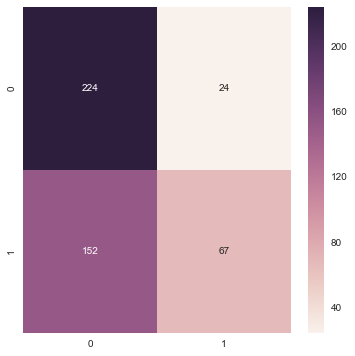

In [38]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_inner,predictions),annot=True, fmt="d")

In [39]:
coeff_df = pd.DataFrame(logmodel.coef_.T,X_train_inner.columns)
coeff_df

,0
0,-3.575097
1,2.407183
2,1.066594


In [40]:
def get_optimal_bet(df,model,max_bet):
    #return pd.Series(df.max(axis=1)*max_bet,index = df.index)
    #return pd.Series(model.predict(df)*df.max(axis=1)*max_bet,index = df.index)
    return pd.Series(np.maximum((model.predict_proba(df) - 0.5)*2,0).T[1] * max_bet,index = df.index)

In [41]:
X_test_outer["bet"] = get_optimal_bet(X_test_outer.drop("bet_ratio",axis = 1),chosen_model,max_bet_per_match)

In [42]:
X_test_outer["right_wrong"] = y_test_outer

In [43]:
X_test_outer.head()

,0,1,2,bet_ratio,bet,right_wrong
1560,0.251613,0.633689,0.114698,1.4,156.306968,1
1561,0.402518,0.239997,0.357485,3.3,0.000000,0
1562,0.372648,0.379202,0.248150,1.8,0.000000,0
1563,0.374577,0.354448,0.270975,3.7,0.000000,0
1564,0.353989,0.259893,0.386118,3.0,0.000000,0


In [44]:
games_worth_betting = X_test_outer[X_test_outer["bet"] > 0]

In [45]:
right_wrong_mean_after = calc_rolling_mean(games_worth_betting,"right_wrong")

In the following plots we can see all test samples against against the samples we will actually bet on:

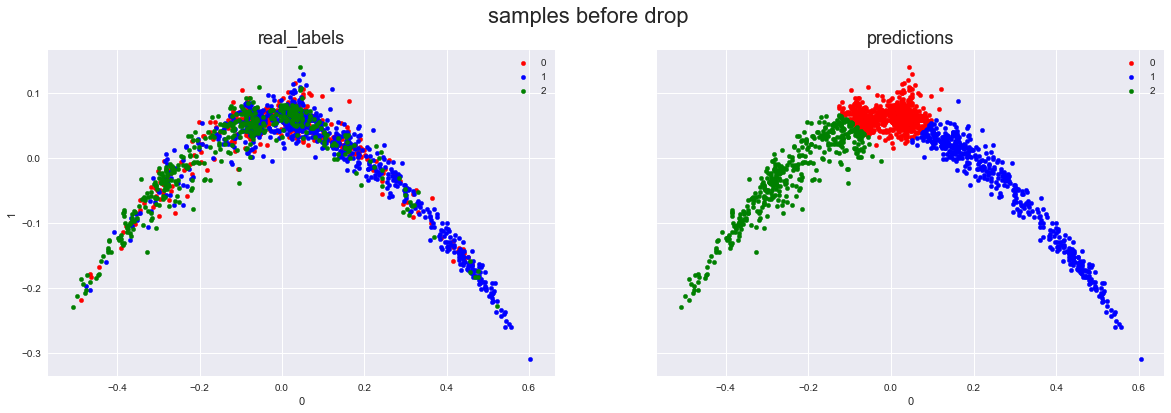

In [46]:
plot_soft_decision_plan("samples before drop",np.array(X_test_outer[["0","1","2"]]),matches_betting_odds_features.loc[X_test_outer.index]["real_score"])

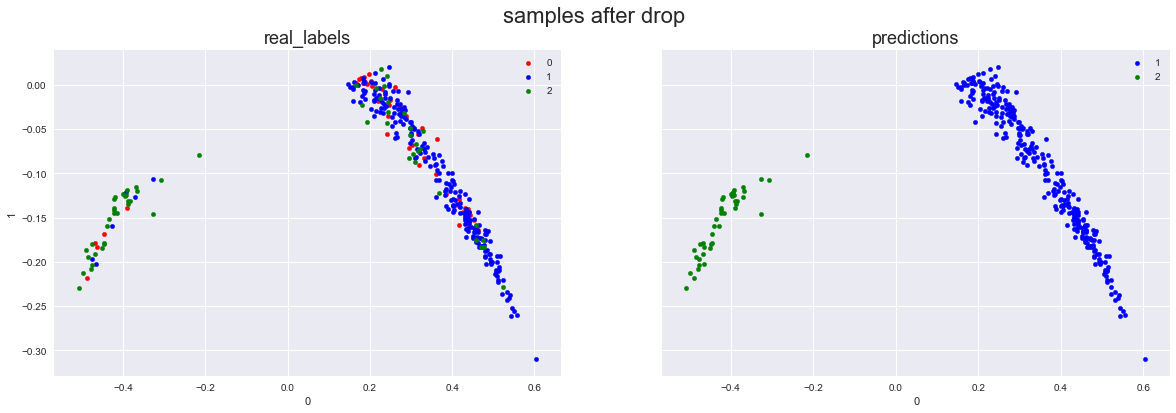

In [47]:
plot_soft_decision_plan("samples after drop",np.array(games_worth_betting[["0","1","2"]]),matches_betting_odds_features.loc[games_worth_betting.index]["real_score"])

Here we can see 2 things:
- first of all we can see that wee have better score than a "monkey decision".
- we can see that using our model to filter all marginal samples we raised our score significantly.

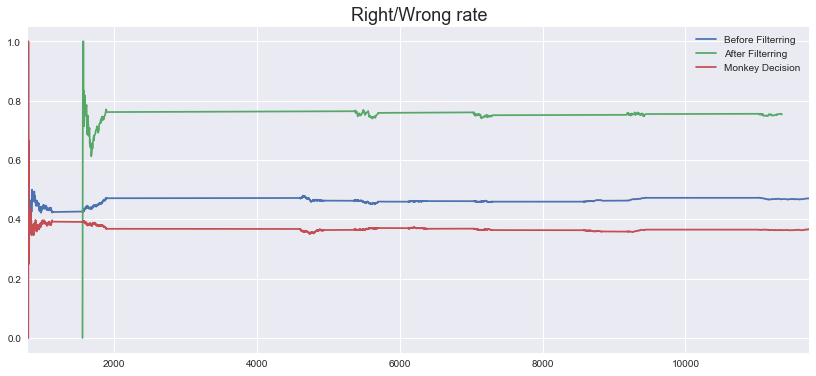

In [48]:
fig,ax = plt.subplots(figsize = (14, 6))
ax.set_title("Right/Wrong rate", fontsize = 18)

right_wrong_mean_before.plot()
right_wrong_mean_after.plot()
right_wrong_mean_monkey.plot()
    
ax.legend(["Before Filterring","After Filterring","Monkey Decision"])

In [49]:
games_worth_betting["profit"] = games_worth_betting["right_wrong"]*(games_worth_betting["bet"]*games_worth_betting["bet_ratio"])-(games_worth_betting["bet"])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
basic_info = ["season","stage","home_team_name","away_team_name","score","predictions"]
bet_info   = ["right_wrong","bet_ratio","bet","profit"]

all_bets                         = new_matches.loc[games_worth_betting.index][basic_info].sort_index()
all_bets[bet_info]               = games_worth_betting[bet_info]
all_bets["profit_through_time"]  = calc_rolling_sum(all_bets,"profit")
all_bets["invest_through_time"]  = calc_rolling_sum(all_bets,"bet")

all_bets.reset_index(drop=True,inplace=True)

all_bets.head()

,season,stage,home_team_name,away_team_name,score,predictions,right_wrong,bet_ratio,bet,profit,profit_through_time,invest_through_time
0,2012/2013,5,Chelsea,Stoke City,1 - 0,1,1,1.40,156.306968,62.522787,0.000000,0.000000
1,2012/2013,5,Tottenham Hotspur,Queens Park Rangers,2 - 1,1,1,1.53,27.009600,14.315088,62.522787,156.306968
2,2012/2013,6,Everton,Southampton,3 - 1,1,1,1.44,76.208957,33.531941,76.837875,183.316568
3,2012/2013,6,Manchester United,Tottenham Hotspur,2 - 3,1,0,1.62,57.409868,-57.409868,110.369816,259.525525
4,2012/2013,6,Norwich City,Liverpool,2 - 5,2,1,1.83,46.414436,38.523982,52.959948,316.935393


And filnaly here we can see our profirts through time:

In [51]:
print("Mean Bet             =", all_bets["bet"].mean(),"$")
print("Max  Bet             =", all_bets["bet"].max(),"$")
print("Min  Bet             =", all_bets["bet"].min(),"$","\n")
print("Mean Profit          =", all_bets["profit"].mean(),"$")
print("Max  Profit          =", all_bets["profit"].max(),"$")
print("Min  Profit          =", all_bets["profit"].min(),"$","\n")
print("Total Money Invested =", all_bets["bet"].sum(),"$")
print("Profits              =", all_bets["profit"].sum(),"$")
print("Profit Percentage    =",(all_bets["profit"].sum()/all_bets["bet"].sum())*100,"%")

Mean Bet             = 129.01359655205346 $
Max  Bet             = 355.615497763 $
Min  Bet             = 0.071206637914 $ 

Mean Profit          = 6.127344956643898 $
Max  Profit          = 88.5219803452 $
Min  Profit          = -294.384552873 $ 

Total Money Invested = 43864.62282769817 $
Profits              = 2083.2972852589255 $
Profit Percentage    = 4.749379228546414 %


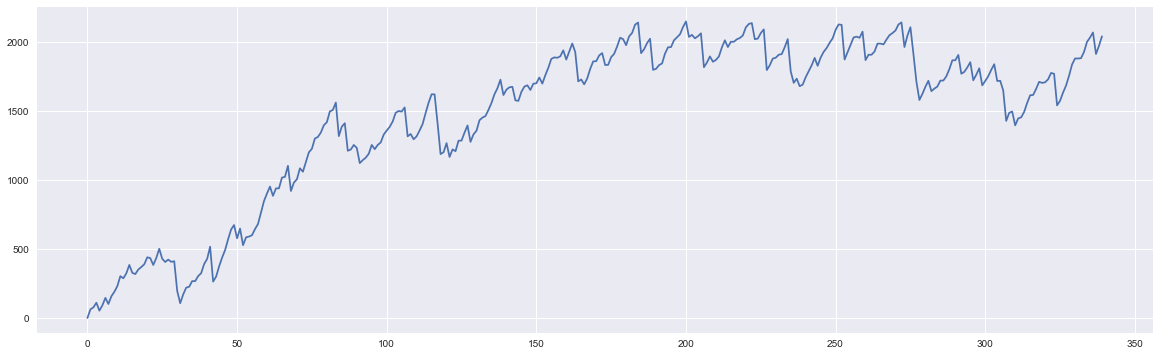

In [52]:
plt.figure(figsize=(20, 6))
plt.plot(all_bets.index,all_bets["profit_through_time"])

### Calculating profits for all models:
We will return on the procces for each model and bookies betting odds and compare them to each other:

In [53]:
basic_info = ["season","stage","home_team_name","away_team_name","score","predictions"]
bet_info   = ["right_wrong","bet_ratio","bet","profit"]
betting_house_dic = {"B365":b365_features, "WH":wh_features, "VC":vc_features }

right_wrong_ratio_before = {}
right_wrong_ratio_after  = {}

def calc_model_profit(model_name,matches,my_features,current_bet,max_bet_per_match,bet_model_name):
    if model_name in bet_houses:
        current_bet = betting_house_dic[model_name]
    else:
        matches[my_features] = my_predictions[model_name]

    new_matches = matches.dropna(axis = 0)
    
    matches_betting_odds_features = new_matches[current_bet].dropna(axis = 0)

    if current_bet != my_features:
        matches_betting_odds_features = trasform_ratios_to_probs(matches_betting_odds_features)

    new_matches["predictions"] = get_naive_predictions(matches_betting_odds_features[current_bet])

    matches_betting_odds_features["predictions"] = new_matches["predictions"]
    matches_betting_odds_features["real_score"]  = new_matches['win_lose_draw']
    matches_betting_odds_features["right_wrong"] = pd.Series(matches_betting_odds_features["real_score"] == matches_betting_odds_features["predictions"],dtype = int)
    matches_betting_odds_features["bet_ratio"]   = get_optimal_bet_ratio(new_matches,bet_houses,matches_betting_odds_features["predictions"])

    right_wrong_ratio_before[model_name] = (matches_betting_odds_features["right_wrong"].sum(),len(matches_betting_odds_features["right_wrong"]))
    
    new_matches_betting_odds_features = matches_betting_odds_features.drop(["predictions","real_score"],axis = 1)
    
    new_features = new_matches_betting_odds_features.drop(["right_wrong"],axis = 1)
    new_lables   = new_matches_betting_odds_features["right_wrong"]
    
    X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(new_features, new_lables, test_size = 0.30, random_state = seed)
    X_train_outer.drop("bet_ratio",axis = 1,inplace = True)
    
    X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(X_train_outer, y_train_outer, test_size = 0.30, random_state = seed)
    
    if bet_model_name == "LogisticRegression":
        bet_model = LogisticRegression()
    else:
        bet_model = RandomForestClassifier(n_estimators=600)    
    bet_model.fit(X_train_inner,y_train_inner)   
    predictions  = bet_model.predict(X_test_inner)
    
    X_test_outer["bet"] = get_optimal_bet(X_test_outer.drop("bet_ratio",axis = 1),bet_model,max_bet_per_match)
    X_test_outer["right_wrong"] = y_test_outer
    games_worth_betting = X_test_outer[X_test_outer["bet"] > 0]
    
    right_wrong_ratio_after[model_name] = (games_worth_betting["right_wrong"].sum(),len(games_worth_betting["right_wrong"]))
    
    games_worth_betting["profit"] = games_worth_betting["right_wrong"]*(games_worth_betting["bet"]*games_worth_betting["bet_ratio"])-(games_worth_betting["bet"])
    
    all_bets                         = new_matches.loc[games_worth_betting.index][basic_info].sort_index()
    all_bets[bet_info]               = games_worth_betting[bet_info]
    all_bets["profit_through_time"]  = calc_rolling_sum(all_bets,"profit")
    all_bets["invest_through_time"]  = calc_rolling_sum(all_bets,"bet")

    all_bets.reset_index(drop=True,inplace=True)

    Mean_Bet             = all_bets["bet"].mean()
    Max_Bet              = all_bets["bet"].max()
    Min_Bet              = all_bets["bet"].min()
    Mean_Profit          = all_bets["profit"].mean()
    Max_Profit           = all_bets["profit"].max()
    Min_Profit           = all_bets["profit"].min()
    Total_Money_Invested = all_bets["bet"].sum()
    Profits              = all_bets["profit"].sum()
    Profit_Percentage    =(all_bets["profit"].sum()/all_bets["bet"].sum())*100 
    
    profit_stat = np.array([[Mean_Bet, Max_Bet, Min_Bet, Mean_Profit, Max_Profit, Min_Profit, Total_Money_Invested, Profits, Profit_Percentage]])
    profit_stat_names = ["Mean Bet", "Max Bet", "Min Bet", "Mean Profit", "Max Profit", "Min Profit", "Total Money Invested", "Profits", "Profit Percentage"]
    profit_stat_df = pd.DataFrame(profit_stat,index=[model_name],columns=profit_stat_names)

    return (all_bets,profit_stat_df)

In [54]:
all_bets_all_models = {}
profit_stat_all_models_dic = {}
profit_stat_all_models = pd.DataFrame()
for model in predictions_models_names:
    all_bets_all_models[model],profit_stat_all_models_dic[model] = calc_model_profit(model,matches,my_features,current_bet,max_bet_per_match,"RandomForestClassifier")
    frames = [profit_stat_all_models, profit_stat_all_models_dic[model]]
    profit_stat_all_models = pd.concat(frames)

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [55]:
categorical_rate = {}
x = ["Before Filterring","After Filterring"]

for ind,df in enumerate([right_wrong_ratio_before,right_wrong_ratio_after]):
    categorical_rate[x[ind]]          = pd.DataFrame(df).T
    categorical_rate[x[ind]].columns  = ["right_guesses","total_num_games"]
    categorical_rate[x[ind]]["ratio"] = categorical_rate[x[ind]]["right_guesses"]/categorical_rate[x[ind]]["total_num_games"]

cc = pd.concat(categorical_rate, axis = 1)

#### Right/Wrong score:
sorted according "Before Filterring":

In [56]:
cc.sort_values([("Before Filterring", 'ratio')], ascending=False)

After Filterring                            \
                          right_guesses total_num_games     ratio   
B365                                276             483  0.571429   
VC                                  300             510  0.588235   
WH                                  313             525  0.596190   
lstm_model                          249             431  0.577726   
RandomForestClassifier              245             404  0.606436   
final_soft_decision                 258             438  0.589041   
nn_model                            212             371  0.571429   
LogisticRegression                  250             420  0.595238   
SVC                                 232             401  0.578554   
DecisionTreeClassifier              235             358  0.656425   
KNeighborsClassifier                221             352  0.627841   

                       Before Filterring                            
                           right_guesses total_num_games     ratio  
B365                                1692            3114  0.543353  
VC                                  1691            3114  0.543031  
WH                                  1686            3114  0.541426  
lstm_model                          1472            3114  0.472704  
RandomForestClassifier              1467            3114  0.471098  
final_soft_decision                 1445            3114  0.464033  
nn_model                            1439            3114  0.462107  
LogisticRegression                  1437            3114  0.461464  
SVC                                 1437            3114  0.461464  
DecisionTreeClassifier              1380            3114  0.443160  
KNeighborsClassifier                1359            3114  0.436416

sorted according "After Filterring":

In [57]:
cc.sort_values([("After Filterring", 'ratio')], ascending=False)

After Filterring                            \
                          right_guesses total_num_games     ratio   
DecisionTreeClassifier              235             358  0.656425   
KNeighborsClassifier                221             352  0.627841   
RandomForestClassifier              245             404  0.606436   
WH                                  313             525  0.596190   
LogisticRegression                  250             420  0.595238   
final_soft_decision                 258             438  0.589041   
VC                                  300             510  0.588235   
SVC                                 232             401  0.578554   
lstm_model                          249             431  0.577726   
B365                                276             483  0.571429   
nn_model                            212             371  0.571429   

                       Before Filterring                            
                           right_guesses total_num_games     ratio  
DecisionTreeClassifier              1380            3114  0.443160  
KNeighborsClassifier                1359            3114  0.436416  
RandomForestClassifier              1467            3114  0.471098  
WH                                  1686            3114  0.541426  
LogisticRegression                  1437            3114  0.461464  
final_soft_decision                 1445            3114  0.464033  
VC                                  1691            3114  0.543031  
SVC                                 1437            3114  0.461464  
lstm_model                          1472            3114  0.472704  
B365                                1692            3114  0.543353  
nn_model                            1439            3114  0.462107

We can see that before filterring the bookies have better score than we have. On the other hand we can achieve better improvement in our models.

#### Profits:

In [58]:
profit_stat_all_models.sort_values("Profits",ascending=False)

,Mean Bet,Max Bet,Min Bet,Mean Profit,Max Profit,Min Profit,Total Money Invested,Profits,Profit Percentage
KNeighborsClassifier,211.434339,500.00000,0.394300,18.239938,1101.211039,-499.444444,74424.887353,6420.458314,8.626763
WH,232.085075,500.00000,0.874487,7.399203,657.884134,-500.000000,121844.664419,3884.581401,3.188142
VC,237.266989,500.00000,2.498016,7.365232,650.680952,-491.527778,121006.164454,3756.268411,3.104196
final_soft_decision,214.246575,500.00000,1.666667,8.269521,880.000000,-478.333333,93840.000000,3622.050000,3.859815
RandomForestClassifier,244.319307,500.00000,1.666667,5.935355,791.666667,-500.000000,98705.000000,2397.883333,2.429343
LogisticRegression,225.595238,500.00000,1.666667,5.106587,759.000000,-493.333333,94750.000000,2144.766667,2.263606
lstm_model,224.624903,500.00000,1.666667,0.936388,629.166667,-500.000000,96813.333333,403.583333,0.416868
DecisionTreeClassifier,197.396683,409.16355,19.397175,-5.009507,330.641834,-409.163550,70668.012627,-1793.403614,-2.537787
SVC,209.962594,495.00000,1.666667,-6.573649,490.000000,-488.333333,84195.000000,-2636.033333,-3.130867
B365,260.258662,500.00000,0.888982,-11.985536,645.555556,-498.333333,125704.933929,-5789.013932,-4.605240


In [59]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = ListedColormap(['r', 'g'])
norm = BoundaryNorm([-np.inf, 0, np.inf], cmap.N)

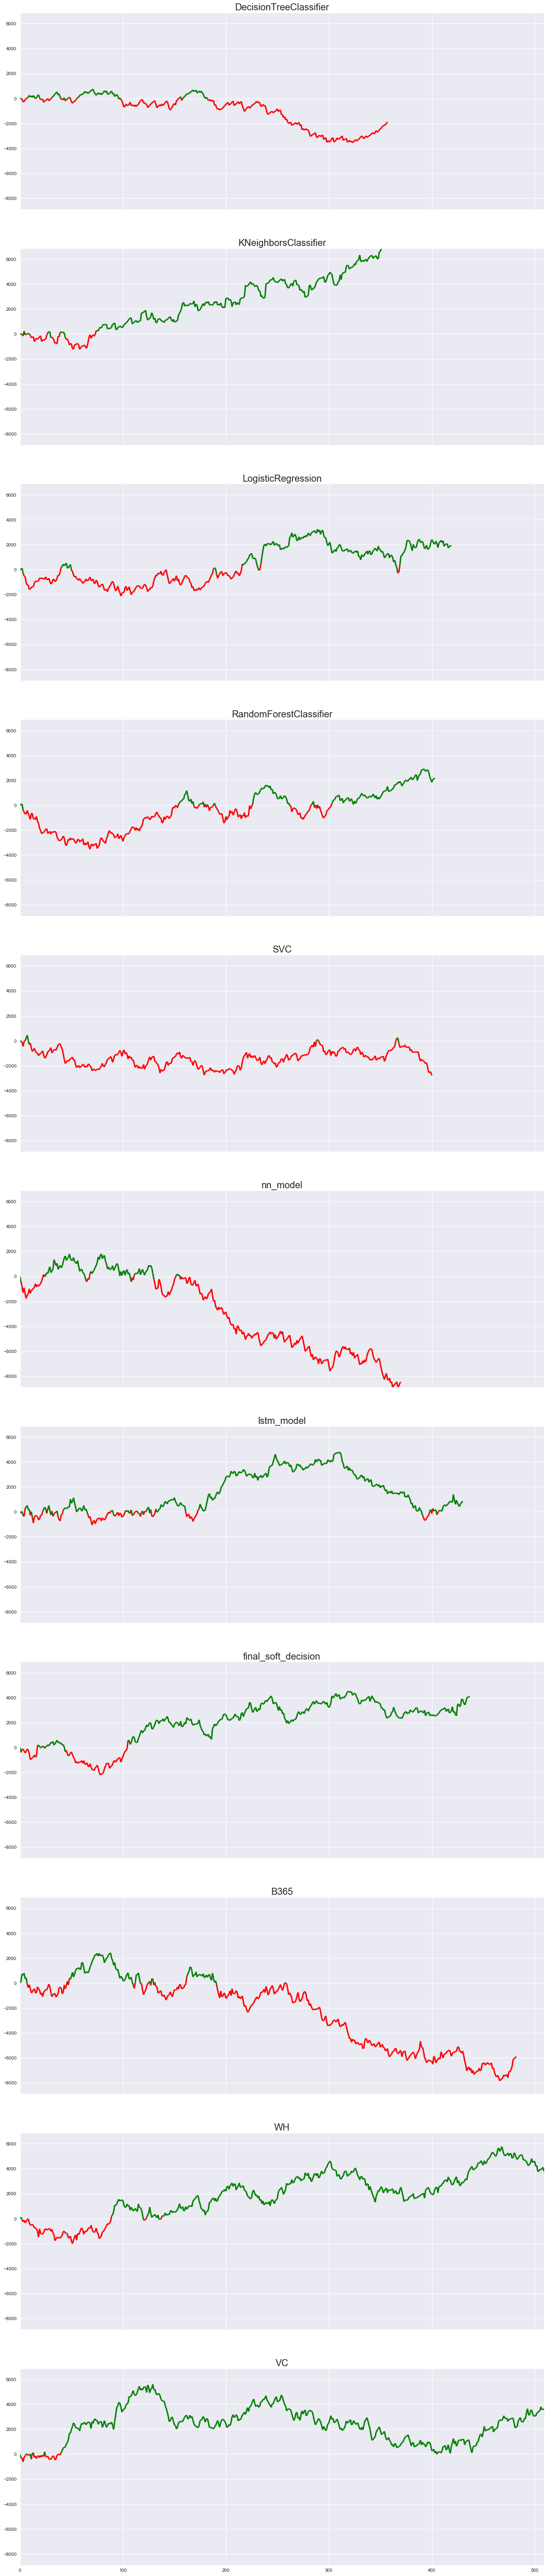

In [60]:
colors = {True:'green', False:'red'}
f, axarr = plt.subplots(len(profit_stat_all_models), 1,figsize=(20, 100), sharex=True, sharey=False)

ymin = ymax = 0
for model in predictions_models_names:
    ymin = min(ymin,all_bets_all_models[model]["profit_through_time"].min())
    ymax = max(ymax,all_bets_all_models[model]["profit_through_time"].max())

for pp,model in enumerate(predictions_models_names):
    temp_df = pd.DataFrame(all_bets_all_models[model]["profit_through_time"],index = all_bets_all_models[model].index, columns=["profit_through_time"] )
    temp_df["sign"] = temp_df["profit_through_time"] >= 0
    temp_df.reset_index(inplace=True)
    
    x = temp_df.as_matrix(columns=["index"])
    x = np.squeeze(x)

    y = temp_df.as_matrix(columns=["profit_through_time"])
    y = np.squeeze(y)
    
    points = np.array([x , y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(y)
    lc.set_linewidth(3)
    axarr[pp].add_collection(lc)
    axarr[pp].set_xlim(x.min(), x.max())
    axarr[pp].set_ylim(ymin, ymax)
    axarr[pp].set_title(model,fontsize = 20)